In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
hp_csv = pd.read_csv('data/compressed1m_hp.csv')
lp_csv = pd.read_csv('data/compressed1m_lp.csv')

In [3]:
print(f'High Peace dimensions: {hp_csv.shape}')
print(f'Low Peace dimensions: {lp_csv.shape}')
print(f'Distinct HP countries: {hp_csv.country.unique().shape[0]}')
print(f'Distinct LP countries: {lp_csv.country.unique().shape[0]}')
print(f'HP average word count per article: {hp_csv.wordCount.mean():.1f}')
print(f'LP average word count per article: {lp_csv.wordCount.mean():.1f}')
print(f'HP min word count: {hp_csv.wordCount.min()}, max word count: {hp_csv.wordCount.max()}')
print(f'LP min word count: {lp_csv.wordCount.min()}, max word count: {lp_csv.wordCount.max()}')
print(f'HP empty articles: {hp_csv.content.isnull().sum()}')
print(f'LP empty articles: {lp_csv.content.isnull().sum()}')

High Peace dimensions: (1000000, 4)
Low Peace dimensions: (1000000, 4)
Distinct HP countries: 10
Distinct LP countries: 10
HP average word count per article: 906.5
LP average word count per article: 435.6
HP min word count: 1, max word count: 149973
LP min word count: 1, max word count: 101327
%age of HP articles under 5k words: 98.15%
%age of LP articles under 5k words: 99.47%
HP empty articles: 0
LP empty articles: 0


# Duplicates

In [4]:
def get_dupes(df, col, preview = False, headsize = 10):
    """
    For a given column of a dataframe, returns a series whose index are the values of col and whose values says whether or not that value has a duplicate.
    Optionally prints the head of the series using boolean preview.
    
    args: df (dataframe), col (column name), preview = False (print head), headsize = 10 (length of head to print))
    returns: boolean series indexed by values of df[col]
    """
    duplicates = df[col].value_counts().apply(lambda t: t>1)
    if preview:
        print(df[df[col].apply(lambda ii: duplicates[ii])].sort_values(col).head(headsize))
    return duplicates
    

In [7]:
textdupes_lp = get_dupes(lp_csv,'content', preview = False)
print(f'LP duplicates: {textdupes_lp.sum()}')
print(f'% of LP articles which are duplicates: {textdupes_lp.sum()/lp_csv.shape[0]*100:.2f}%')
del textdupes_lp

textdupes_hp = get_dupes(hp_csv,'content', preview = False)
print(f'HP duplicates: {textdupes_hp.sum()}')
print(f'% of HP articles which are duplicates: {textdupes_hp.sum()/hp_csv.shape[0]*100:.2f}%')
del textdupes_hp

LP duplicates: 7732
% of LP articles which are duplicates: 0.77%
HP duplicates: 13344
% of HP articles which are duplicates: 1.33%


Check by country

In [8]:
def duplicated_across_feature(df, col1, col2):
    """Checks if there are duplicates in col1 across different features in col2
     For example, col1 could be the text column, col2 the country column, to check if there are text duplicates
     across different countries.
     
     args: 
         df: dataframe
         col1: column to check for duplicates
         col2: feature to count duplicates against
    returns: 
        dataframe giving count of distinct col2 values where duplicate col1 values occur"""
    col1dupe_col2 = df.groupby(col1)[col2].apply(lambda t: t.unique())
    col1dupe_col2.name = col2+'_list'
    col1dupe_col2 = col1dupe_col2.reset_index()
    col1dupe_col2[col2+'_count'] = col1dupe_col2[col2+'_list'].apply(lambda t:len(t))
    return col1dupe_col2

The number of duplicates occurring across countries is relatively low. I will remove these entirely for now, but we could keep one copy for each country where it was published, eg.

In [9]:
lp_countrydupes = duplicated_across_feature(lp_csv, 'content', 'country')
print(f'LP articles duplicated across multiple countries: {(lp_countrydupes.country_count > 1).sum()}')

hp_countrydupes = duplicated_across_feature(hp_csv, 'content', 'country')
print(f'HP articles duplicated across multiple countries: {(hp_countrydupes.country_count > 1).sum()}')

#LP

#Values of lp_csv[content] which are duplicated across different countries
lp_dup_drops = lp_countrydupes[lp_countrydupes.country_count > 1].content.values

#Remove lp articles which are duplicates across countries entirely
lp_clean = lp_csv[~lp_csv.content.isin(lp_dup_drops)].copy()
n = lp_clean.shape[0]

print(f'Removing ALL LP articles duplicated across countries dropped {lp_csv.shape[0] - n} rows.')

#then drop remaining (within-country) duplicates (keeping one)
lp_clean.drop_duplicates(inplace = True)
print(f'Dropping LP duplicates (within country, keeping one) removed {n - lp_clean.shape[0]} additional rows.')
n = lp_clean.shape[0]

print(f'LP articles after removing any article duplicated across countries, and all but one remaining (within-country) duplicate: {n}')

del lp_dup_drops, lp_csv

#HP

#Values of hp_csv[content] which are duplicated across different countries
hp_dup_drops = hp_countrydupes[hp_countrydupes.country_count > 1].content.values

#Remove hp articles which are duplicates across countries entirely
hp_clean = hp_csv[~hp_csv.content.isin(hp_dup_drops)].copy()
n = hp_clean.shape[0]

print(f'Removing ALL HP articles duplicated across countries dropped {hp_csv.shape[0] - n} rows.')

#then drop remaining (within-country) duplicates (keeping one)
hp_clean.drop_duplicates(inplace = True)
print(f'Dropping HP duplicates (within country, keeping one) removed {n - hp_clean.shape[0]} additional rows.')
n = hp_clean.shape[0]

print(f'HP articles after removing any article duplicated across countries, and all but one remaining (within-country) duplicate: {n}')

del hp_dup_drops, hp_csv

LP articles duplicated across multiple countries: 35
HP articles duplicated across multiple countries: 68
Removing ALL articles duplicated across countries dropped 70 rows.
Dropping duplicates (within country, keeping one) removed 3796 additional rows.
LP articles after removing any article duplicated across countries, and all but one remaining (within-country) duplicate: 996134
Removing ALL articles duplicated across countries dropped 144 rows.
Dropping duplicates (within country, keeping one) removed 16267 additional rows.
HP articles after removing any article duplicated across countries, and all but one remaining (within-country) duplicate: 983589


# EDA

## Distributions

In [13]:
print(f'High Peace dimensions: {hp_clean.shape}')
print(f'Low Peace dimensions: {lp_clean.shape}')
print(f'Distinct HP countries: {hp_clean.country.unique().shape[0]}')
print(f'Distinct LP countries: {lp_clean.country.unique().shape[0]}')
print(f'HP average word count per article: {hp_clean.wordCount.mean():.1f}')
print(f'LP average word count per article: {lp_clean.wordCount.mean():.1f}')
print(f'HP min word count: {hp_clean.wordCount.min()}, max word count: {hp_clean.wordCount.max()}')
print(f'LP min word count: {lp_clean.wordCount.min()}, max word count: {lp_clean.wordCount.max()}')

High Peace dimensions: (983589, 4)
Low Peace dimensions: (996134, 4)
Distinct HP countries: 10
Distinct LP countries: 10
HP average word count per article: 915.1
LP average word count per article: 436.2
HP min word count: 1, max word count: 149973
LP min word count: 1, max word count: 101327


### HP vs. LP

%age of HP articles under 5k words: 98.12%



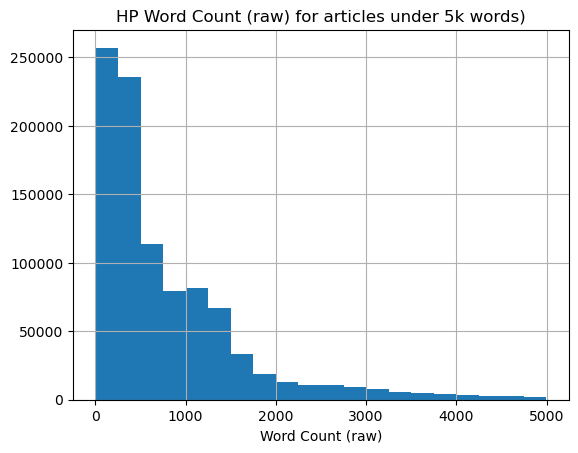


%age of LP articles under 5k words: 99.47%



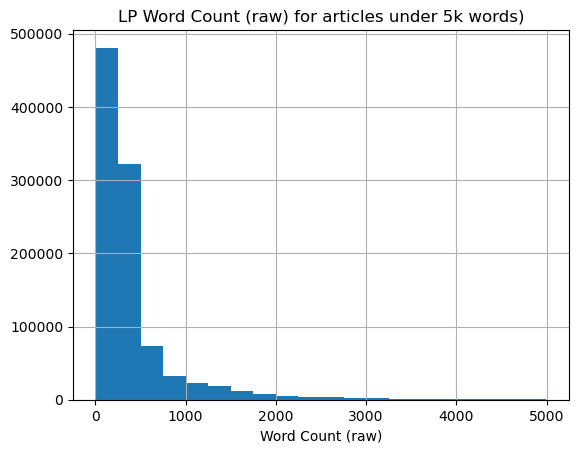

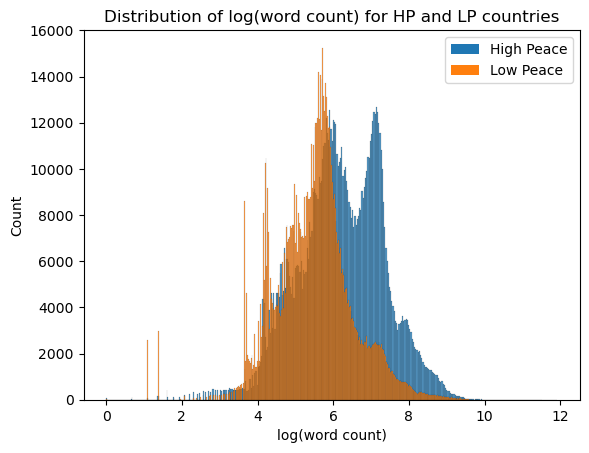

In [16]:
print(f'%age of HP articles under 5k words: {hp_clean[hp_clean.wordCount < 5e3].shape[0]/hp_clean.shape[0]*100:.2f}%\n')


hp_clean[hp_clean.wordCount < 5e3].hist(bins = 20)
plt.title('HP Word Count (raw) for articles under 5k words)')
plt.xlabel('Word Count (raw)')
plt.show()

print(f'\n%age of LP articles under 5k words: {lp_clean[lp_clean.wordCount < 5e3].shape[0]/lp_clean.shape[0]*100:.2f}%\n')
plt.show()

lp_clean[lp_clean.wordCount < 5e3].hist(bins = 20)
plt.title('LP Word Count (raw) for articles under 5k words)')
plt.xlabel('Word Count (raw)')
plt.show()

#Distribution of word counts in HP vs. LP
fig, ax = plt.subplots()
sns.histplot(x = np.log(hp_clean.wordCount), ax = ax, label = 'High Peace')
sns.histplot(x = np.log(lp_clean.wordCount), ax = ax, label = 'Low Peace')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[k] for k in [0,2]], [labels[k] for k in [0,2]])
ax.set(title = 'Distribution of log(word count) for HP and LP countries', xlabel = 'log(word count)')
plt.show()

### By country

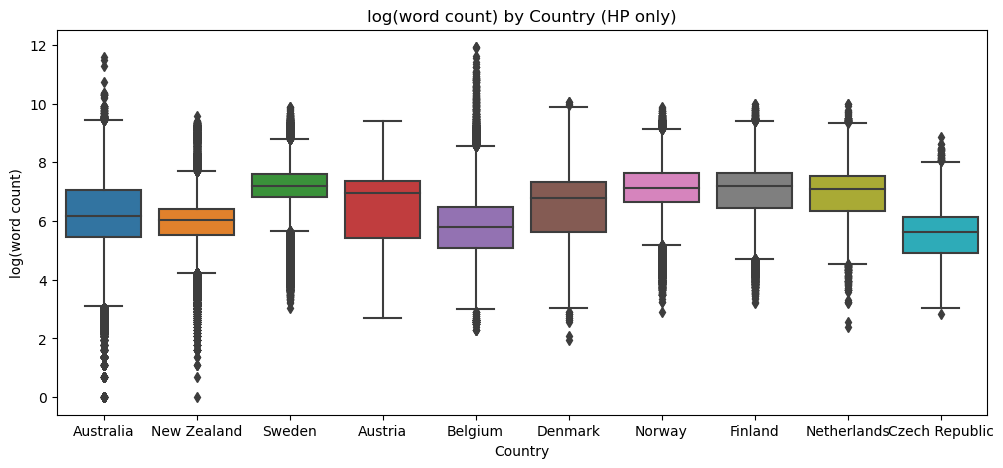

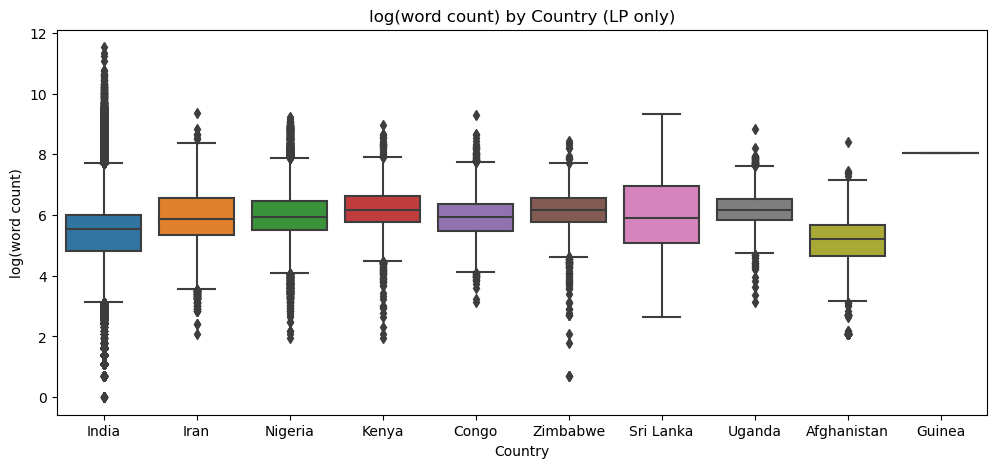

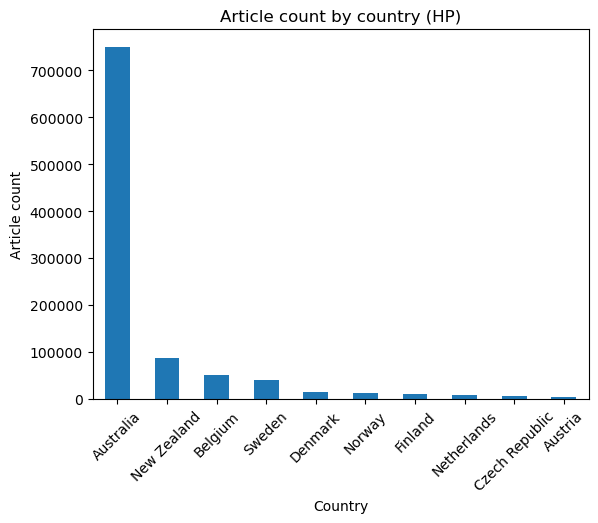

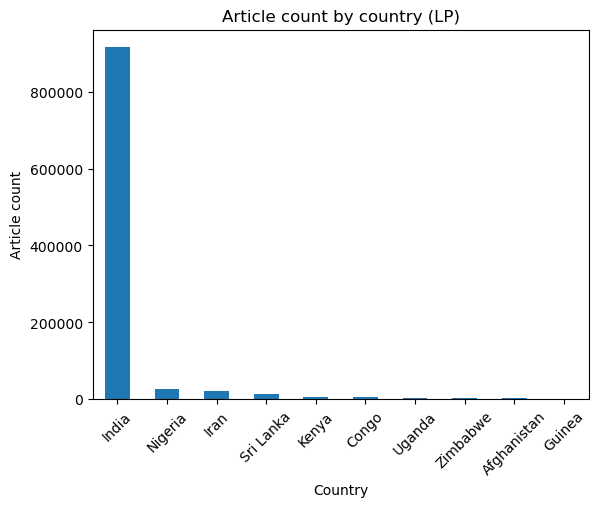

In [17]:
#Distribution of word counts by country in HP
fig, ax = plt.subplots(figsize = (12,5))
sns.boxplot(x = hp_clean['country'], y = np.log(hp_clean['wordCount']), ax = ax)
ax.set(title = 'log(word count) by Country (HP only)', xlabel = 'Country', ylabel = 'log(word count)')
plt.show()

#Distribution of word counts by country in LP
fig, ax = plt.subplots(figsize = (12,5))
sns.boxplot(x = lp_clean['country'], y = np.log(lp_clean['wordCount']), ax = ax)
ax.set(title = 'log(word count) by Country (LP only)', xlabel = 'Country', ylabel = 'log(word count)')
plt.show()

#HP article count by country
hp_clean.country.value_counts().plot(kind = 'bar')
plt.title('Article count by country (HP)')
plt.xlabel('Country')
plt.xticks(rotation = 45)
plt.ylabel('Article count')
plt.show()

#LP article count by country
lp_clean.country.value_counts().plot(kind = 'bar')
plt.title('Article count by country (LP)')
plt.xlabel('Country')
plt.xticks(rotation = 45)
plt.ylabel('Article count')
plt.show()

Summary:

LP countries have significantly shorter articles on average, with the average word count being 500 words shorter for LP than HP. Both datasets have some unusually large articles, with the vast majority being under 5k words (above 98% for each). Additionally, each dataset itself is highly imbalanced w.r.t. country. The proportions of articles by country within each class are shown below:

In [18]:
print('High peace:\n\n', hp_clean.country.value_counts(normalize = True).apply(lambda x: f'{x*100:.2f}%'))
print('\n Low peace:\n\n', lp_clean.country.value_counts(normalize = True).apply(lambda x: f'{x*100:.2f}%'))

High peace:

 Australia         76.18%
New Zealand        8.89%
Belgium            5.27%
Sweden             4.00%
Denmark            1.41%
Norway             1.28%
Finland            1.11%
Netherlands        0.83%
Czech Republic     0.60%
Austria            0.43%
Name: country, dtype: object

 Low peace:

 India          91.93%
Nigeria         2.71%
Iran            2.18%
Sri Lanka       1.37%
Kenya           0.52%
Congo           0.50%
Uganda          0.29%
Zimbabwe        0.27%
Afghanistan     0.23%
Guinea          0.00%
Name: country, dtype: object


# Encoding for word stats